In [1]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from astropy.cosmology import Planck18
import h5py
import seaborn as sns
import pandas as pd

# Marginal Models
$$
\pi (M_c, q, z) = \pi(M_c, q) \pi(z) = \Big( \int_z dz \pi(M_c, q, z) \Big) \Big( \int_{M_c, q} dM_cdq \pi(M_c, q, z) \Big)
$$

In [2]:
lenp = 10
Nobs_plot = np.zeros(lenp)

with h5py.File("../Uncorrelated_Pop/mock_data.h5",'r') as hf:
    for i in range(lenp):
        Nobs_plot[i] = np.array(hf['Ndet'+str(i)])
hf.close()

Nobs_plot = Nobs_plot[:8]

In [3]:
h_marg = []
Om_marg = []

with h5py.File("../Uncorrelated_Pop/inference_full_result.h5",'r') as hf:
    for i in range(lenp):
        h_marg.append(np.array(hf['h'+str(i)]))
        Om_marg.append(np.array(hf['Om'+str(i)]))
hf.close()

h_marg = np.array(h_marg)
Om_marg = np.array(Om_marg)

h_marg = h_marg[:8]
Om_marg = Om_marg[:8]

# Correlated Population

In [4]:
h_full = []
Om_full = []

with h5py.File("../Correlated_Pop/inference_full_result.h5",'r') as hf:
    for i in range(lenp):
        h_full.append(np.array(hf['h'+str(i)]))
        Om_full.append(np.array(hf['Om'+str(i)]))
hf.close()

h_full = np.array(h_full)
Om_full = np.array(Om_full)

h_full = h_full[:8]
Om_full = Om_full[:8]

# Plots

In [5]:
data = {
    'Number of Detected BNSs': np.array([np.repeat(Nobs_plot, 1000), np.repeat(Nobs_plot, 1000)]).flatten().astype(np.int64),
    'Hubble Constant (in km/s/Mpc)': np.array([h_full.flatten(), h_marg.flatten()]).flatten()*100,
    'Dark Matter Density': np.array([Om_full.flatten(), Om_marg.flatten()]).flatten(),
    'Population': np.array([np.full(h_full.flatten().shape[0], r'Correlated Pop: $\pi(M_c, q, z) \neq \pi(M_c, q)\pi(z)$', dtype=object), 
            np.full(h_marg.flatten().shape[0], r'Uncorrelated Pop: $\pi(M_c, q, z) = \pi(M_c, q)\pi(z)$', dtype=object)]).flatten()
}

df = pd.DataFrame(data)
print(df)

       Number of Detected BNSs  Hubble Constant (in km/s/Mpc)  \
0                           15                      63.514679   
1                           15                      63.342094   
2                           15                      59.927727   
3                           15                      64.437584   
4                           15                      57.302685   
...                        ...                            ...   
15995                     3034                      68.466049   
15996                     3034                      67.230423   
15997                     3034                      66.847763   
15998                     3034                      67.263580   
15999                     3034                      68.241829   

       Dark Matter Density                                         Population  
0                 0.396501  Correlated Pop: $\pi(M_c, q, z) \neq \pi(M_c, ...  
1                 0.573702  Correlated Pop: $\pi(M_c, q, z)

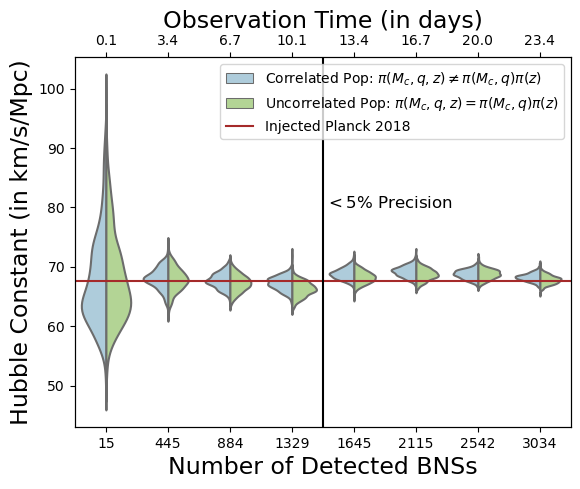

In [10]:
Tobs = np.linspace(0.1,30,10)[:8]
sns.color_palette('colorblind')
my_palette = {r'Correlated Pop: $\pi(M_c, q, z) \neq \pi(M_c, q)\pi(z)$': "#A6CEE3", r'Uncorrelated Pop: $\pi(M_c, q, z) = \pi(M_c, q)\pi(z)$': "#B2DF8A"}

fig, ax1 = plt.subplots()

sns.violinplot(x='Number of Detected BNSs', y='Hubble Constant (in km/s/Mpc)', hue='Population', data=df, split=True, palette=my_palette, inner=None)
plt.axhline(Planck18.H0.value, color='brown', label='Injected Planck 2018')
plt.xlabel('Number of Detected BNSs', fontsize=17)
plt.ylabel('Hubble Constant (in km/s/Mpc)', fontsize=17)


ax2 = ax1.twiny()
ax2.set_xlim(ax1.get_xlim())
ax2.set_xticks(ax1.get_xticks())
ax2.set_xticklabels(['{:.1f}'.format(i) for i in Tobs])
ax2.set_xlabel('Observation Time (in days)', fontsize=17)
ax1.legend()

ax1.axvline(3.5, color='black')
ax1.text(5.6, 80, r'$<5\%$ Precision', fontsize=12, ha='right')
plt.show()
fig.savefig('H0.pdf', bbox_inches='tight')

In [7]:
z_plot = np.linspace(0.,3.,5000)
n = -1
h_plot = h_marg[n]
Om_plot = Om_marg[n]

Hz = np.zeros((h_marg[-1].shape[0], z_plot.shape[0]))
for i in range(h_marg[-1].shape[0]):
    Hz[i] = 100*h_plot[i]*(Om_plot[i]*(1+z_plot)**3+(1-Om_plot[i]))**0.5
Hz = Hz.T
#Hz.shape = (N_z_plot, Nsamples)
Hz.shape

(5000, 1000)

Redshift where the H(z) errorbar is smallest= 0.34506901380276056


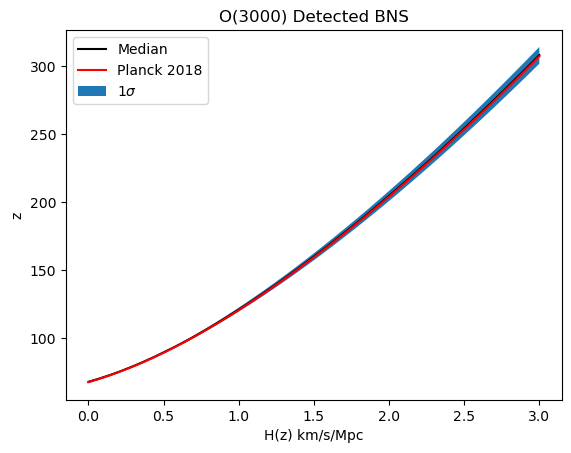

In [8]:
Hz1pzlq = np.quantile(Hz, 0.16, axis=1)
Hz1pzhq = np.quantile(Hz, 0.84, axis=1)
Hz1pzmed = np.median(Hz, axis=1)

plt.plot(z_plot, Hz1pzmed, color='k', label='Median')
plt.plot(z_plot, Planck18.H(z_plot).value, color='r', label='Planck 2018')
plt.fill_between(z_plot, Hz1pzlq, Hz1pzhq, label=r'$1\sigma$')
plt.legend()
plt.xlabel('H(z) km/s/Mpc')
plt.ylabel('z')
plt.title('O(3000) Detected BNS')

print('Redshift where the H(z) errorbar is smallest=', z_plot[np.argmin(abs(Hz1pzlq-Hz1pzhq))])

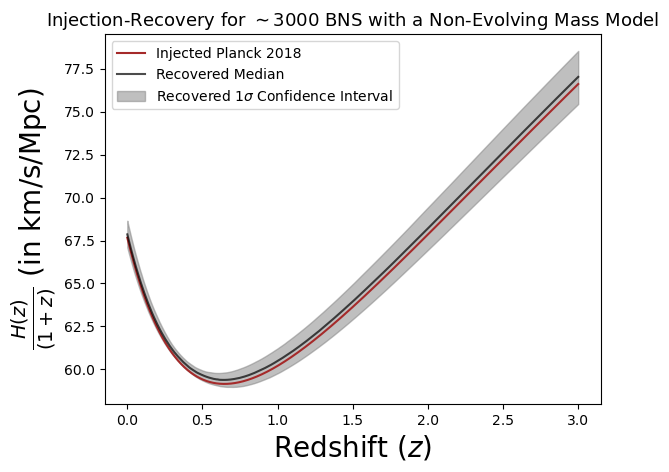

In [9]:
Hzd1pz = Hz/(1+z_plot[:,None])
Hzd1pzlq = np.quantile(Hzd1pz, 0.16, axis=1)
Hzd1pzhq = np.quantile(Hzd1pz, 0.84, axis=1)
Hzd1pzmed = np.median(Hzd1pz, axis=1)

plt.plot(z_plot, 100*Planck18.h*(Planck18.Om0*(1+z_plot)**3+(1-Planck18.Om0))**0.5/(1+z_plot), color='brown', label='Injected Planck 2018')
plt.plot(z_plot, Hzd1pzmed, color='k', alpha=0.7, label='Recovered Median')
plt.fill_between(z_plot, Hzd1pzlq, Hzd1pzhq, color='grey', alpha=0.5, label=r'Recovered $1\sigma$ Confidence Interval')
plt.legend()
plt.title(r'Injection-Recovery for $\sim3000$ BNS with a Non-Evolving Mass Model', fontsize=13)
plt.xlabel(r'Redshift ($z$)', fontsize=20)
plt.ylabel(r'$\frac{H(z)}{(1+z)}$ (in km/s/Mpc)', fontsize=20)
plt.savefig('Hzdiv1pz.pdf', bbox_inches='tight')